In [1]:
import pandas as pd
import numpy as np
import logging
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import truncnorm


In [2]:
# Create logger to help with information reporting
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
# Ability to turn logging on and off
logging_on = False
if not logging_on:
    logging.disable(logging.CRITICAL)
else:
    logging.disable(logging.NOTSET)

In [3]:
# Variables that are the same across simulations
num_years = 15
num_simulations = 10000000
wet_well = True

# Load data first
oil_prices = pd.read_excel("Analysis_Data.xlsx", header=2)

# Simulated oil prices
prices = np.random.triangular(
    left=oil_prices.loc[0:num_years-1, "Low Oil Price"].values[None, :],
    mode=oil_prices.loc[0:num_years-1, "AEO2023 Reference"].values[None, :],
    right=oil_prices.loc[0:num_years-1, "High Oil Price"].values[None, :],
    size=(num_simulations, num_years)
)

# This is the same across all simulations (only for sim one well)
operating_costs = np.random.normal(loc=2.25, scale=0.30, size=(num_simulations, num_years))
annual_salary = np.random.triangular(
    left=172_000,
    mode=215_000, 
    right=279_000,
    size=num_simulations
)[:, None] * np.ones(num_years)


# Year 0 Costs
- The cost of these items depends on the number of wells in the project.
- Uncertain assumptions include leased acres per well, which are Normally distributed with a mean of 600 and a standard deviation of 50 acres per well (lower number of wells means lower number of acres to buy); the price per acre is $960.
- The number of seismic sections per well is Normally 
distributed with a mean of 3 sections and a standard deviation of 0.35 per well (lower number 
of wells means lower number of sections to purchase data on); the seismic costs per section are 
$43,000.

In [4]:
def initial_costs(num_simulations, wet_well=False):
    """Calculate initial costs including seismic, lease, and well preparation."""
    # Drilling costs (in thousands)
    price_06 = 2279.8  # 2006 price average
    years = np.arange(2007, 2026)  # Years to simulate
    prices = np.full((num_simulations, len(years)), price_06)
    changes_2007_2012 = np.random.normal(0.1314912658158, 0.17656869616614107, size=(num_simulations, 6))  # For years 2008-2012
    changes_2013_2015 = np.random.triangular(-0.22, -0.0917, -0.07, size=(num_simulations, 3))  # For years 2013-2015
    changes_2016_2025 = np.random.triangular(0.02, 0.05, 0.06, size=(num_simulations, 10))     # For years 2016-2025
    all_changes = np.hstack((changes_2007_2012, changes_2013_2015, changes_2016_2025))
    cumulative_factors = np.cumprod(1 + all_changes, axis=1)
    prices[:, :] *= cumulative_factors
    drilling_cost = (prices[:, -1] * 1000)

    logging.info(f"Mean simulated drilling_cost: {drilling_cost.mean():,.2f}")
    # Seismic and lease costs
    price_per_acre = 960
    total_acres_price = np.random.normal(loc=600,scale=50,size=num_simulations) * price_per_acre
    logging.info(f"Mean simulated total_acres_price: {total_acres_price.mean():,.2f}")

    price_per_section = 43_000
    total_sections_price = np.random.normal(loc=3,scale=0.35,size=num_simulations) * price_per_section
    logging.info(f"Mean simulated total_sections_price: {total_sections_price.mean():,.2f}")

    total_lease_cost = total_acres_price + total_sections_price

    # Well preparation costs
    if wet_well:
        well_prep_cost = np.random.normal(loc=390_000,scale=50_000,size=num_simulations)
    else:
        well_prep_cost = np.zeros(shape=num_simulations)
    logging.info(f"Mean simulated well_prep_cost: {well_prep_cost.mean():,.2f}")
    # Calculate total year 0 costs
    year_0_costs = total_lease_cost + well_prep_cost + annual_salary[:,0] + drilling_cost
    logging.info(f"Mean simulated year_0_costs: {year_0_costs.mean():,.2f}")
    return year_0_costs

# Production Risk
1. IP. The initial production rate tested from the drilled well. This is the rate the oil is produced at 
Year 1. 
2. Decline Rate. A declining production rate that describes the annual decrease in production from 
the beginning of the year to the end of the same year. To simplify the problem, we will assume 
each well has the same decline rate for every year of its life, but this could be different across 
wells.

In [5]:
def standardize(data):
    return (data - np.mean(data)) / np.std(data)

def destandardize(standardized_data, original_data):
    return standardized_data * np.std(original_data) + np.mean(original_data)

In [6]:
def production(num_simulations):
    """Calculate oil production over 15 years."""
    # Generate initial parameters
    initial_production_rate = np.random.lognormal(mean=6,sigma=0.28,size=num_simulations)
    logging.info(f"Mean simulated initial_production_rate: {initial_production_rate.mean():,.2f}")
    rate_decline = np.random.uniform(low=0.15,high=0.32,size=num_simulations)
    logging.info(f"Mean simulated rate_decline: {rate_decline.mean():,.2f}")

    # Add correlation between parameters
    corr_matrix = np.array([[1, 0.64], [0.64, 1]])
    chol_decomp= sp.linalg.cholesky(corr_matrix, lower = False)
    both_rates = np.array([
        standardize(rate_decline),
        standardize(initial_production_rate)
    ])
    
    corr_rates = chol_decomp @ both_rates
    
    final_rates = np.array([
        destandardize(corr_rates[0], rate_decline),
        destandardize(corr_rates[1], initial_production_rate)
    ])
    logging.info(f"Mean simulated correlated initial_production_rate: {final_rates[1].mean():,}")
    logging.info(f"Mean simulated correlated rate_decline: {final_rates[0].mean():,}")

    # Calculate production for each year
    barrels_per_year = np.zeros((num_simulations, num_years))
    production_rate = final_rates[1].copy()  # Start with initial production
    
    for year in range(num_years):
        start_rate = production_rate
        end_rate = start_rate * (1 - final_rates[0])  # Apply decline rate
        barrels_per_year[:, year] = 365 * (start_rate + end_rate) / 2
        production_rate = end_rate  # Set up for next year
        
    logging.info(f"Mean barrels across all years: {barrels_per_year.mean():,}")
    for year in range(num_years):
        logging.info(f"Mean simulated barrels for year {year+1}: {barrels_per_year[:,year].mean():,.2f}")
    return barrels_per_year

# Revenue Risk

In [7]:
def revenue(oil_production, prices):
    """Calculate revenue based on production and oil prices."""
    logging.info(f"Mean simulated revenue: {(prices * oil_production).mean():,.2f}")
    return prices * oil_production

Net revenue Interest. Oil companies must purchase leases from mineral interest holders. Along 
with paying cash to retain the drilling and production rights to a property for a specified time 
period, the lessee also generally retains some percentage of the oil revenue produced in the 
form of a royalty. The percentage that the producing company retains after paying all royalties is 
the net revenue interest (NRI). **Our model represents a typical West Texas scenario with an 
assumed NRI distributed Normally with a mean of 75% and a standard deviation of 2%. This 
calculation is done per well for the entire life of the well.**

# Operating Expenses

In [8]:
def expenses(num_simulations,oil_revenue, oil_production, operating_costs):
    """Calculate total expenses including NRI, operating costs, and taxes."""
    # Calculate NRI expenses
    nri = np.random.normal(loc=0.25, scale=0.02, size=(num_simulations, 1))
    nri_expense = nri * oil_revenue
    logging.info(f"Mean simulated NRI expense: {nri_expense.mean():,.2f}")
    
    revenue_after_nri = oil_revenue - nri_expense
    
    # Calculate operating costs and taxes
    operating_costs_expense = operating_costs * oil_production
    logging.info(f"Mean simulated operating costs expense: {operating_costs_expense.mean():,.2f}")
    severance_taxes_expense = 0.046 * revenue_after_nri
    logging.info(f"Mean simulated severance taxes expense: {severance_taxes_expense.mean():,.2f}")
    
    return nri_expense + operating_costs_expense + severance_taxes_expense + annual_salary

def net_present_value(year_0_costs, revenue, expenses, wacc=0.10):
    """Calculate net present value of the investment."""
    fnr = revenue - expenses
    logging.info(f"Mean simulated free net revenue: {fnr.mean():,.2f}")
    # Create initial NPV as minus initial costs
    npv = np.full(num_simulations, -year_0_costs)
    
    for year in range(num_years):
        npv += fnr[:, year] / ((1 + wacc) ** (year + 1))
    
    return npv

# Well Simulation Function

In [9]:
def simulate_well(num_simulations, wet_well=False):
    """Simulate a single well's financial performance."""
    # Initial costs
    logging.info(f"Mean simulated oil prices: {prices.mean():,.2f}")
    logging.info(f"Mean simulated operating costs: {operating_costs.mean():,.2f}")
    logging.info(f"Mean simulated annual salary: {annual_salary.mean():,.2f}")
    
    year_0_costs = initial_costs(num_simulations, wet_well)
    
    if wet_well:
        oil_production = production(num_simulations)
        oil_revenue = revenue(oil_production, prices)
        oil_expenses = expenses(num_simulations, oil_revenue, oil_production, operating_costs)
        npv = net_present_value(year_0_costs, oil_revenue, oil_expenses)
        return npv
    else:
        return -year_0_costs

In [10]:
wet_well_sim = simulate_well(num_simulations, wet_well = True)
wet_well_sim_df = pd.DataFrame(wet_well_sim)
print(f"Average NPV for wet wells: ${wet_well_sim.mean():,.2f}")

KeyboardInterrupt: 

In [ ]:
dry_well_sim = simulate_well(num_simulations,wet_well= False)

## Phase 3 

In [11]:
def probProduce(n = 10):
    # Hydrocarbons
    mu = .99      # Mean
    sigma = .05   # Standard deviation
    lower = 0   # Lower bound
    upper = 1   # Upper bound

    a, b = (lower - mu) / sigma, (upper - mu) / sigma

    hydro = pd.Series(truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n))
    
     # Reservoir
    mu = .8     # Mean
    sigma = .1   # Standard deviation
    lower = 0   # Lower bound
    upper = 1   # Upper bound

    a, b = (lower - mu) / sigma, (upper - mu) / sigma

    reservoir = pd.Series(truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n))
    
    prob = hydro * reservoir
    return(prob)

In [12]:
def wells(n = 10):
    wellSamp = (round(pd.Series(np.random.uniform(10,30,size= n)),0))
    wet = []
    for well in wellSamp:
        prob = probProduce(n = int(well))
        numWet = np.random.binomial(n = 1, p = prob)
        wet.append(numWet.sum())
    dry = (pd.Series(wellSamp) - pd.Series(wet))
    dry = [int(x) for x in dry]
    wet = [int(x) for x in wet]
    return([list(wet),list(dry)])

In [13]:
import random
def projectNPV(n = 10):
    wellList = wells(n = n)
    npvList = []
    for i in range(0,n):
        wet = wellList[0][i]
        dry = int(wellList[1][i])
        wetVal = pd.Series(random.sample(list(wet_well_sim), wet)).sum()
        dryVal = pd.Series(random.sample(list(dry_well_sim), dry)).sum()
        
        npv = wetVal + dryVal
        npvList.append(npv)
    return(npvList)
        
        

## Results:

### Histograms of Hydro and Reservoir

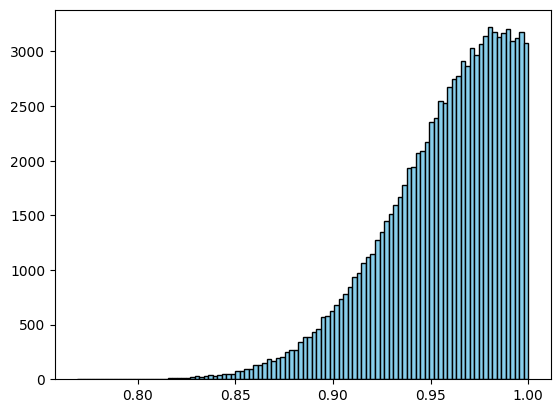

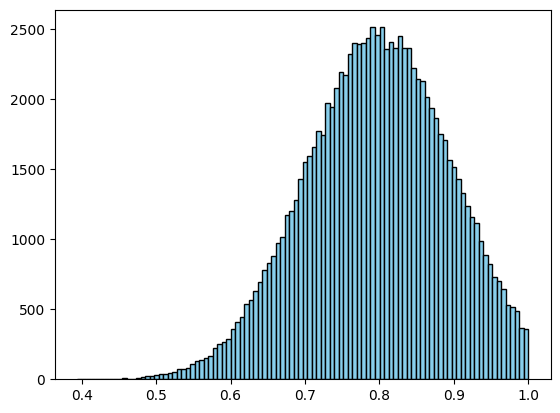

In [ ]:
# Hydrocarbons
mu = .99      # Mean
sigma = .05   # Standard deviation
lower = 0   # Lower bound
upper = 1   # Upper bound

a, b = (lower - mu) / sigma, (upper - mu) / sigma

hydro = pd.Series(truncnorm.rvs(a, b, loc=mu, scale=sigma, size=100000))

    # Reservoir
mu = .8     # Mean
sigma = .1   # Standard deviation
lower = 0   # Lower bound
upper = 1   # Upper bound

a, b = (lower - mu) / sigma, (upper - mu) / sigma

reservoir = pd.Series(truncnorm.rvs(a, b, loc=mu, scale=sigma, size=100000))

plt.hist(hydro, bins=100,  color='skyblue', edgecolor='black')
plt.show()

plt.hist(reservoir, bins=100,  color='skyblue', edgecolor='black')
plt.show()


### Histogram for proportion of wells producing

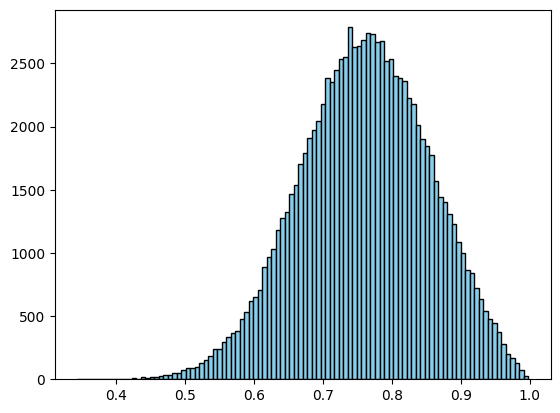

In [14]:
prob = probProduce(n = 100000)

plt.hist(prob, bins=100,  color='skyblue', edgecolor='black')
plt.show()

In [15]:
prob.describe()

count    100000.000000
mean          0.760134
std           0.093568
min           0.343531
25%           0.696801
50%           0.761834
75%           0.826526
max           0.998082
dtype: float64

### Histogram for number of wells producing

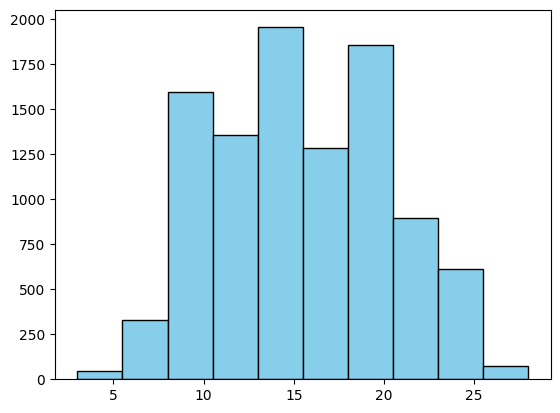

In [17]:
well = wells(n= 10000)
wet = []
for i in range(0,len(well[0])):
    wet.append(well[0][i])

plt.hist(wet,  color='skyblue', edgecolor='black')
plt.show()

In [21]:
projects = projectNPV(10000)

In [23]:
import joblib as jl
jl.dump(projects,"projects.pkl")


['projects.pkl']

In [24]:
proj = pd.Series(projects) / 1000000

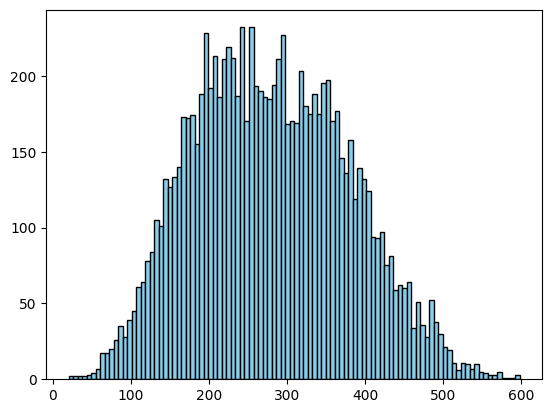

In [25]:
plt.hist(proj, bins  =100, color = "skyblue",edgecolor = "black")
plt.show()

In [26]:
proj.describe()

count    10000.000000
mean       279.470986
std         99.102909
min         20.181663
25%        203.402697
50%        274.690554
75%        351.318271
max        597.772075
dtype: float64

In [27]:
VAR = proj.quantile(.05)



In [28]:
CVAR = proj[proj <= VAR].mean()

CVAR

np.float64(101.18753172955073)

In [30]:
VAR

np.float64(127.82964012097605)